## Analyze rates_delay_loss made by test_env.py
* ex. all traces (train one by one - in any order (random, gap to baseline etc.))
* The important thing is that you have tested on multiple traces (they are keys in l_rate)

In [4]:
import pandas as pd
import numpy as np
from plot_cdf import plot_cdf, plot_cdf_multiple
import matplotlib.pyplot as plt
import json
import os
import glob

In [5]:
# dataset = "ghent"
# conf_name = f"test_random_traces_ghent_v2"

# dataset = "norway"
# conf_name = f"random_traces_norway"

# dataset = "NY"
# conf_name = f"random_NY"

conf_name = "random_low_bandwidth"

In [6]:
prefix = "../output/rates_delay_loss_test_"
suffix = ".pickle"

pickle_path = prefix+conf_name+suffix
print(pickle_path)
l_rate = pd.read_pickle(pickle_path)
time_step = 200
reward_profile=0
print(time_step)

../output/rates_delay_loss_test_random_low_bandwidth.pickle
200


In [10]:
pd.DataFrame(l_rate['./traces/trace_300k.json'])

,bandwidth_prediction,sending_rate,receiving_rate,delay,loss_ratio,log_prediction,reward
0,40145,33240.0,33240.0,124.000000,0.0,0.207929,-0.062676
1,10533,21200.0,21200.0,103.714286,0.0,0.007779,-0.033246
2,9999,21000.0,21000.0,103.833333,0.0,0.000000,-0.033976
3,19276,33680.0,33680.0,105.000000,0.0,0.098183,-0.011054
4,31685,30240.0,30240.0,105.000000,0.0,0.172526,-0.018108
...,...,...,...,...,...,...,...
296,60718,45280.0,45280.0,106.857143,0.0,0.269823,0.007774
297,10112,50240.0,50240.0,108.000000,0.0,0.001680,0.014865
298,61769,45600.0,45600.0,106.857143,0.0,0.272391,0.008430
299,10243,61080.0,61080.0,108.142857,0.0,0.003604,0.036735


Trace name:  ../traces/WIRED_200kbps.json  |  WIRED_200kbps


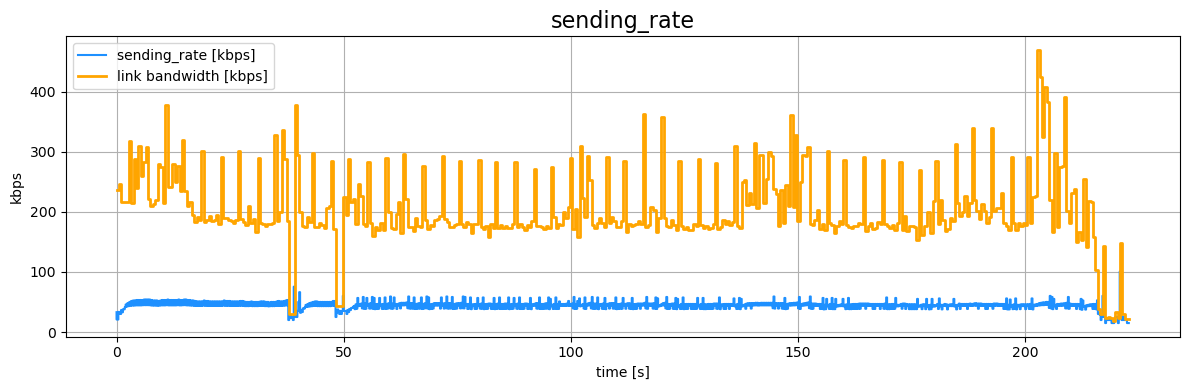

In [20]:
plot_gcc = False
len_traces = [] #length of each trace in ms

for key in l_rate.keys():
    
    if "traces" in key:
        dataset = "opennetlab"
    elif "Ghent" in key:
        dataset = "ghent"
    elif "Norway" in key:
        dataset = "norway"
    elif "NY" in key:
        dataset = "NY"
    else:
        print("Unknown dataset")
    
#     print(f"Trace: {key}")
    colors = iter(["dodgerblue", "teal", "indianred", "olive", "yellow", "green"])

    # for metric in ["bandwidth_prediction", "receiving_rate", "sending_rate", "delay", "loss_ratio", "reward"]:
    for metric in ["sending_rate"]: # "delay", "loss_ratio", "reward"
        #Define capacity
        
        if dataset == "opennetlab":
            trace_name = "../" + key.split("/")[1] + "/" + key.split("/")[2]
            REAL_NAME = key.split("/")[-1].split(".")[0]
        elif dataset == "ghent":
            trace_name = os.path.join("../new_data/logs_all_4G_Ghent_json", os.path.basename(key))
            REAL_NAME = os.path.basename(key).split(".")[0]
        elif dataset == "norway":
            trace_name = os.path.join("../new_data/Norway_3G_data_json", os.path.basename(key))
            REAL_NAME = os.path.basename(key).split(".")[0]
        elif dataset == "NY":
            trace_name = os.path.join("../new_data/NY_4G_data_json", os.path.basename(key))
            REAL_NAME = os.path.basename(key).split(".")[0]
        else:
            print("Wrong dataset name")
    
        print("Trace name: ", trace_name, " | ", REAL_NAME)
        
        
        if plot_gcc:
            pickle_path_gcc = f"../apply_model/results_gcc/rates_delay_loss_gcc_{REAL_NAME}.pickle"
            l_rate_gcc = pd.read_pickle(pickle_path_gcc)

            if l_rate_gcc["trace_name"] != REAL_NAME:
                print("Trace not the same as GCC")

        with open(trace_name, "r") as f:
            d = json.load(f)

        df = pd.DataFrame(d["uplink"]["trace_pattern"])
        time = [0] + list(df["duration"].cumsum())
        capacities = [df["capacity"].iloc[0]] + list(df["capacity"])

        len_traces.append(time[-1])
        

        df_rate = pd.DataFrame(l_rate[key][metric], columns=[metric])
        if plot_gcc and (metric != "reward"):
            df_rate_gcc = pd.DataFrame(l_rate_gcc[metric], columns=[metric])
            df_rate = df_rate.join(df_rate_gcc, rsuffix="_gcc")

        t = np.arange(len(df_rate))*time_step
        df_rate["time"] = t
        df_rate.set_index("time", inplace=True)


        if metric in ["bandwidth_prediction", "sending_rate", "receiving_rate"]:

            plt.figure(figsize=(12,4))
            plt.title(metric, fontsize=16)
            # color=next(colors)
            plt.step(df_rate.index/1000, df_rate[metric]/1000, label=f"{metric} [kbps]", color="dodgerblue")
            plt.step([i/1000 for i in time], capacities, lw=2, label="link bandwidth [kbps]", color="orange")
            if plot_gcc and (metric != "reward"):
                plt.step(df_rate.index, df_rate[f"{metric}_gcc"]/1000, label=f"{metric} GCC [kbps]", color="red")
            plt.legend()
            plt.ylabel("kbps")
            plt.xlabel("time [s]")
            plt.grid()
            
            if dataset == "norway":
                plt.ylim((0, 1000))
            elif dataset == "ghent":
                plt.ylim((0, 10000))
            elif dataset == "NY":
                plt.ylim((0, 20000))
            else:
                # if REAL_NAME == "WIRED_200kbps":
                #     plt.xlim((0, 50000))
                if REAL_NAME == "WIRED_35mbps":
                    plt.ylim((0, 40000))
                elif REAL_NAME == "4G_700kbps":
                    plt.ylim(0, 1500)
                elif REAL_NAME == "4G_3mbps":
                    plt.ylim(0,8000)
                elif REAL_NAME == "4G_500kbps":
                    plt.ylim(0,1600)
                elif REAL_NAME == "5G_12mbps":
                    plt.ylim(0,20000)
                elif REAL_NAME == "5G_13mbps":
                    plt.ylim(0,20000)
            plt.tight_layout()

        else:
            plt.figure(figsize=(12,4))
            plt.title(metric, fontsize=16)
            plt.step(df_rate.index/1000, df_rate[metric], label=f"{metric}", color="dodgerblue")
            if plot_gcc and (metric != "reward"):
                plt.step(df_rate.index/1000, df_rate[f"{metric}_gcc"], label=f"{metric} GCC", color="red")
            plt.ylabel(metric)
            plt.xlabel("time [s]")
            plt.legend()
            plt.grid()
            if metric == "reward":
                plt.tight_layout()
                plt.ylim(-1.05,1.05)
#                 plt.savefig(f"./plots/reward_{REAL_NAME}_{reward_profile}.png")
            elif metric in ["Rl", "Ru", "Rd"]:
                plt.ylim(-1.05,1.05)
            
        plt.show()
        print("\n")

In [19]:
222800/1000

222.8

In [16]:
df_rate

,sending_rate
time,
0,33240.0
200,21200.0
400,21000.0
600,33680.0
800,30240.0
...,...
222000,20160.0
222200,20160.0
222400,20160.0
